In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass, field, fields
from typing import List, Dict, Tuple
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from copy import deepcopy
import os


## Configs

In [6]:

@dataclass
class Configs:
    
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = True

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'cifar10'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    DIM_CONTEXT : int = 1
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (3, 32, 32))
    
    #...model params:
    MODEL : str = 'Unet32x32'
    NUM_CHANNELS : int = 64
    CHANNEL_MULT : List[float] = field(default_factory = lambda : [1, 2, 2, 2])
    NUM_RES_BLOCKS : int = 2
    NUM_HEADS : int = 4
    DIM_HIDDEN : int = 64 
    ATTENTION_RESOLUTIONS : str = "16"
    DROPOUT : float = 0.1

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    EPOCHS: int = 30
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    FIX_SEED : int = None  
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cfm params:
    DYNAMICS : str = 'CondFlowMatch'
    SIGMA : float = 0.001
    AUGMENTED : bool = False
    T0 : float = 0.0
    T1 : float = 1.0

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 1e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'NeuralODE'
    SOLVER : str = 'euler'
    NUM_SAMPLING_STEPS : int = 100
    SENSITIVITY : str = 'adjoint'
    ATOL : float = None
    RTOL : float = None
    NUM_GEN_SAMPLES: int = 10 


    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


## Datamodule

Files already downloaded and verified
Files already downloaded and verified
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 50000, validation size: 10000, testing sizes: 0


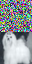

In [7]:
from cmb.data.cifar import CIFARDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
cifar = CIFARDataClass(conf)
dataloader = DefineDataloader(cifar)
transform = ToPILImage()

for batch in dataloader.train:
    pair = torch.cat([batch.source[0].squeeze(), batch.target[0].squeeze()], dim=1)
    img = transform(pair)
    break

img

## Train CFM model on CIFAR-10

In [8]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.architectures.unet_cifar import UNet32x32 
from cmb.models.trainers import CFMTrainer

dynamics = ConditionalFlowMatching(conf)
unet = UNet32x32(conf)
model = CFMTrainer(dynamics, unet, cifar)
model.train()

number of training parameters: 8952323
number of training parameters: 8952323
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 50000, validation size: 10000, testing sizes: 0
INFO: using  4 GPUs...


epochs:   0%|          | 0/30 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [36,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: [37,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [52,0,0], thread: 

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/df630/CMB/src/cmb/models/architectures/unet_cifar.py", line 919, in forward
    x = self.unet(t, x, y=context)
  File "/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/df630/CMB/src/cmb/models/architectures/unet_cifar.py", line 623, in forward
    h = module(h, emb)
  File "/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/df630/CMB/src/cmb/models/architectures/unet_cifar.py", line 64, in forward
    x = layer(x, emb)
  File "/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/df630/CMB/src/cmb/models/architectures/unet_cifar.py", line 208, in forward
    return checkpoint(self._forward, (x, emb), self.parameters(), self.use_checkpoint)
  File "/home/df630/CMB/src/cmb/models/architectures/utils_cifar.py", line 330, in checkpoint
    return func(*inputs)
  File "/home/df630/CMB/src/cmb/models/architectures/unet_cifar.py", line 228, in _forward
    h = h + emb_out
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


975: indexSelectLargeIndex: block: [27,0,0], thread: [53,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [54,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [55,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [56,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [57,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [58,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [27,0,0], thread: [59,0,0] Assertion `srcIndex < srcSelectD

 thread: [23,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [24,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [25,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [26,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [27,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [28,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [11,0,0], thread: [29,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda

## image generation

In [6]:
from cmb.models.pipelines import CFMPipeline

pipeline = CFMPipeline(trained_model=model, config=conf)
input_source = torch.randn(conf.BATCH_SIZE, *conf.INPUT_SHAPE)
pipeline.generate_samples(input_source)

INFO: neural ODE solver with euler method and steps=100


  0%|          | 0/1 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


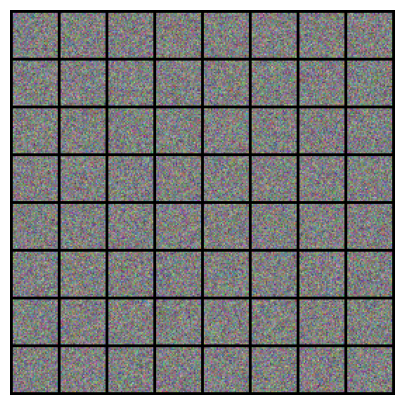

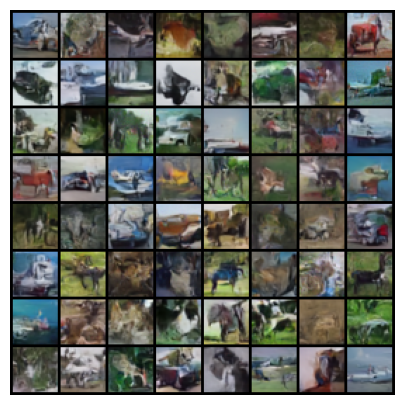

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

img_generated = pipeline.trajectories[-1, :] 

grid_img_gen = torchvision.utils.make_grid(img_generated[:64], nrow=8, padding=2, normalize=True)
grid_img_src = torchvision.utils.make_grid(input_source[:64], nrow=8, padding=2, normalize=True)


plt.figure(figsize=(5, 5))
plt.imshow(grid_img_src.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(grid_img_gen.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()


## FID computation

In [ ]:
from cleanfid import fid
score = fid.compute_fid(
    gen=img,
    dataset_name="cifar10",
    batch_size=16,
    dataset_res=128,
    num_gen=128,
    dataset_split="train",
    mode="legacy_tensorflow",
)
print()
print("FID has been computed")
print()
print("FID: ", score)
